# Assignment 2c Notebook: Competitive Co-Evolution of Pac-Man Controllers and Ghost Controllers

**IMPORTANT REMINDER:** This assignment is weighted the same as Assignments 2a and 2b *combined*!

For the final assignment in this course, you will use your cumulative understanding and implementation of genetic programming (GP) to implement the competitive co-evolution of Pac-Man controllers and Ghost controllers! From your previous assignment implementations, copy over the following files:

* `base_evolution.py`
* `fitness.py`
* `genetic_programming.py`
* `selection.py`
* `tree_genotype.py`

**If you implemented your parse trees in a separate file, copy that file over as well.** In addition, you will need to import this file in the following code cell.

If you receive any feedback about the implementation of your algorithm in Assignment 2b, please address any problems before you conduct your experiment for Assignment 2c. You may also copy your previous notebooks over if you wish, but be careful to not overwrite the other files in the repo, as we may have made modifications to them.

Recall that you should be launching this notebook using the `EC-env` conda environment. If you are not in the `EC-env` environment, terminate the notebook server, activate the environment with `conda activate EC-env`, and restart the notebook server.

As usual, **be sure to read all of this notebook.** Start by executing the next cell.

In [5]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser
!pip install pytest

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams['figure.figsize'] = (10.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 8.0
plt.rcParams['figure.titlesize'] = 12.0
plt.rcParams['axes.titlesize'] = 12.0
plt.rcParams['axes.labelsize'] = 8.0
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['savefig.dpi'] = 400.0
plt.rcParams['animation.embed_limit'] = 2048

import multiprocessing

multiprocessing.set_start_method('fork', force=True)

import os
import random
import statistics
from IPython.display import display, HTML
from pathlib import Path
from scipy import stats
from snake_eyes import read_config
from fitness import play_GPac
from gpac import render_game
from genetic_programming import GeneticProgrammingPopulation
from tree_genotype import *
from selection import *
from histogram import *

print('The first cell has been executed!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The first cell has been executed!


## Config Parsing
The config file for co-evolution is a little more complex than previous assignments, so we'll give some code to extract per-species parameters in the following cell. We'll explain how to use this later.

In [6]:
from copy import deepcopy

# Define a function for splitting the config into configs for each population
def split_config(config):
    pac_config = dict()
    ghost_config = dict()

    for key in config:
        if key.startswith('pac_'):
            pac_config[key.partition('_')[-1]] = config[key]

        elif key.startswith('ghost_'):
            ghost_config[key.partition('_')[-1]] = config[key]

        else:
            pac_config[key] = config[key]
            ghost_config[key] = config[key]

    # deepcopy to pre-emptively avoid weird bugs when you multiprocess your runs
    return deepcopy(pac_config), deepcopy(ghost_config)

## Ghost Controllers
Assuming you already have a working implementation of a GP algorithm for Pac-Man controllers, implementing Ghost controllers should be relatively easy. The only real difference is that, for Ghosts, the `G` terminal returns the distance to the nearest *other* Ghost, and there is an additional `M` terminal returning the distance to Pac-Man (or the nearest Pac-Man, if attempting a deliverable with multiple Pac-Man agents in the game). While the algorithms you used to create, reproduce, and evaluate Pac-Man trees should still be applicable here, you need to make sure your code can cleanly handle the different terminal sets. There are many different ways to accomplish that, and it is up to you to choose how.

Also note that **we have changed the way games are scored in order to make co-evolution more competetive**. Previously, Pacman would lose points if he was caught by a Ghost, based on the time remaining. In assignments 2a and 2b, this helped differentiate between Pacman agents when the Ghosts were controlled randomly, and hence largely incapable of catching Pacman. With intelligent Ghosts, survival is much harder, and Pacman agents typically evolve to solely focus on avoiding Ghosts at all costs. Removing this penalty somewhat mitigates that problem. You do **not** need to change your code to handle this, just keep in mind the scores you see will be largely inflated compared to the scores you observed in the previous two assignments.

## Multi-Population Fitness Evaluation
Competitive fitness in GPac has the quirk of only being relative to encountered opponents. Since opponents belong to populations that are evolving, **you must re-calculate fitness for all individuals at each generation**. Additionally, since it is impractical to play against all opponents, it is also necessary to *approximate* fitness in some way. In practice, you would approximate fitness of an individual through competition with a sample of several opponents. In this assignment, however, we allow for each individual to play against as few as a single opponent per generation to manage computational cost.

As a result of the complex nature of competitive fitness for games like GPac, you will typically perform more fitness evaluations per generation than evolution using the same parameters on a problem with an absolute fitness metric. Given a positive integer `sample_size`, each individual in the larger population should compete in precisely `sample_size` games. Games should be distributed over the smaller population as uniformly as possible. To be specific, if the larger population has $x$ individuals and the smaller population has $y$ individuals, each individual in the smaller population should play in either $sample\_size * \lfloor x / y \rfloor$ games or $sample\_size * \lceil x / y \rceil$ games (i.e., some of them may need to play one extra game as a "remainder"). This can be accomplished with simple loops. If an individual plays more than once in a single generation, calculate its fitness as the average of all games they played that generation.

The default `sample_size` provided is `2`. Note that we allow any value for `sample_size` in this assignment, including `1`, though in practice you would want a much higher value. Playing against only one opponent gives a very rough estimate of an agent's overall quality, and is very likely to produce fitness values that are wildly inaccurate; two opponents is better, but still extremely small in practice. This was in fact already a problem on assignments 2a and 2b. However, increasing the sample size requires either raising the evaluation limit proportionally or accepting fewer generations of evolution. To get the best solutions possible from your implementation, you would need to raise both `sample_size` and the evaluation limit, and then re-tune your config. We encourage you to do this if you're interested in seeing what your implementation is truly capable of! However, an important thing to consider in this assignment is that each evaluation will now take roughly *four times* as long to complete, as you now have four different tree-based agents that must evaluate states, instead of one tree-based agent and three random agents.

In the below cell, implement `competitive_population_evaluation`, a function that accepts multiple populations as inputs, forms competition match-ups of individuals from the input populations, performs fitness evaluations with the match-ups, and assigns appropriate `fitness` and `base_fitness` members to each individual from the input populations. This should broadly resemble the single-population evaluation functions you implemented in several previous assignments. We've added comments that lay out a recommended approach, but you are free to approach implementing this algorithm however you wish, subject to a few requirements and subtleties:

1. Your code must support any possible combination of population sizes.
2. Your code must support any positive integer value of `sample_size`.
3. You should shuffle both populations at the start of the function in order to avoid potential biases introduced by selection algorithms.
4. You should make an effort to ensure each sampled game should be played against a different opponent. You could play against the same opponent multiple times under a few edge cases, but this should be extremely rare.

**Note**: The `play_GPac` function returns the game score, but Ghost `base_fitness` should be calculated as the negation of game score. Recall also that each GP tree receives a parsimony penalty and you should be mindful of the distinctions between `base_fitness` instead of `fitness`. Note that you do *not* need to store game logs, unless you wish to for your own purposes, as we will be playing exhibition games after evolution concludes for the purposes of visualization.

In [7]:
def competitive_population_evaluation(pac_population, ghost_population,
                                      pac_parsimony_coefficient,
                                      ghost_parsimony_coefficient,
                                      sample_size, **kwargs):
    # TODO: Perform matchmaking to generate pairs of individuals, one from each population.
    # Make sure to read the above description very carefully; matchmaking is not trivial,
    # and your submitted code MUST be able to handle arbitrary population sizes,
    # including cases where the two populations have different sizes.

    random.shuffle(pac_population)
    random.shuffle(ghost_population)

    matches = []
    larger_population = None
    length_larger_population = None

    # Find which population is larger
    if len(pac_population) >= len(ghost_population):
        larger_population = "M"
        length_larger_population = len(pac_population)
    else:
        larger_population = "G"
        length_larger_population = len(ghost_population)

    number_of_matches = 0

    # Loop to create matches so individual in the larger population play sample_size games
    for i in range(length_larger_population):
        if larger_population == "M":
            for _ in range(sample_size):
                ghost_controller = ghost_population[number_of_matches % len(ghost_population)]
                matches.append((pac_population[i], ghost_controller))
                number_of_matches += 1
        else:
            for _ in range(sample_size):
                pac_controller = pac_population[number_of_matches % len(pac_controller)]
                matches.append((pac_controller, ghost_population[i]))
                number_of_matches += 1

    # TODO: Evaluate the matches with the play_Gpac function.
    # Hint: play_GPac(pac_controller, ghost_controller, **kwargs)

    # Dictionaries to keep track of each controller and their associated list of scores
    pac_to_scores = {}
    ghosts_to_scores = {}

    # Plays each match and appends the score of the game to the pac controller's corresponding score list 
    # and -score to the ghost controller's corresponding score list
    for pac_controller, ghost_controller in matches:
        score, _ = play_GPac(pac_controller, ghost_controller, **kwargs)
        if pac_controller not in pac_to_scores:
            pac_to_scores[pac_controller] = [score]
        else:
            pac_to_scores[pac_controller].append(score)

        if ghost_controller not in ghosts_to_scores:
            ghosts_to_scores[ghost_controller] = [-score]
        else:
            ghosts_to_scores[ghost_controller].append(-score)
        
    # TODO: Calculate and assign fitness and base_fitness members.
    # Don't forget each population may have different parsimony coefficients,
    # and that you need to handle cases where an individual played multiple games.

    # Calculates the base fitness of each controller by averaging its scores across games
    # Finds the fitness of each controller by doing base fitness - (size of controller * controller parsimony coefficient)
    for pac_controller, scores in pac_to_scores.items():
        pac_controller.base_fitness = statistics.mean(scores)
        pac_controller.fitness = pac_controller.base_fitness - (pac_controller.genes.size * pac_parsimony_coefficient)

    for ghost_controller, scores in ghosts_to_scores.items():
        ghost_controller.base_fitness = statistics.mean(scores)
        ghost_controller.fitness = ghost_controller.base_fitness - (ghost_controller.genes.size * ghost_parsimony_coefficient)
        

If you want to test your implementation, you may do so in the following cell. For this final assignment, we're leaving it up to you to exercise your implementation at your own discretion.

In [32]:
combined_config = read_config('configs/2c/green_config.txt', globals(), locals())
pac_config, ghost_config = split_config(combined_config)
pac_population = GeneticProgrammingPopulation(**pac_config['ea'], **pac_config).population
ghost_population = GeneticProgrammingPopulation(**ghost_config['ea'], **ghost_config).population
# Make pac_population and ghost_population however you wish, then call the below function
competitive_population_evaluation(pac_population, ghost_population, **pac_config['fitness_kwargs'], **pac_config['game'])

## Competitive Co-Evolution
Below is a high-level diagram of a 2-population competitive co-evolutionary algorithm. Using your Pac-Man controllers, Ghost controllers, and the `competitive_population_evaluation` function you just implemented, you should have all the necessary components to implement competitive co-evolution!
**Note**: there's a typo in the below figure and both cycles should perform **whole-population** Competitive Fitness Evaluation (instead of evaluating only the children, as implied by the left cycle).

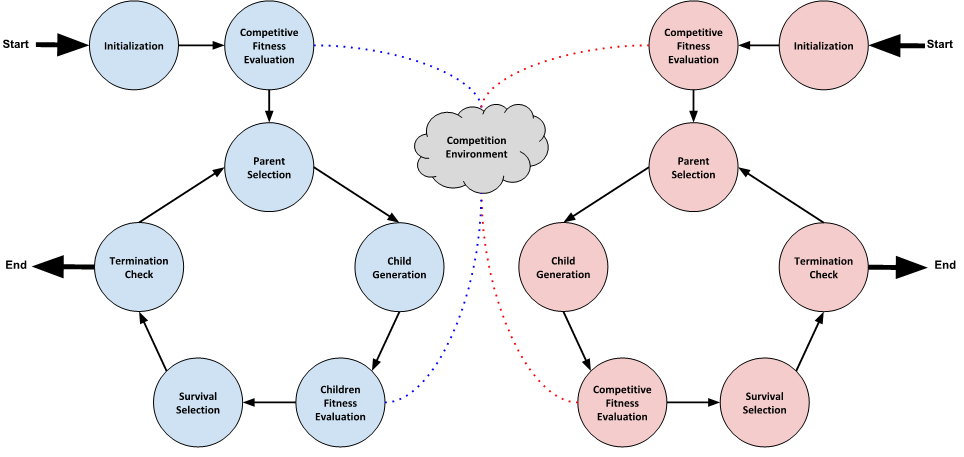

As mentioned previously, the quirks of competitive fitness require that you modify your typical evolutionary cycles slightly. Namely, you must re-evaluate and recalculate fitness for all individuals each generation. This means that, each generation, each population's children should be combined with the adults, and then **all individuals in both populations** should be re-evaluated with your `competitive_population_evaluation` function. Make sure, however, that your `competitive_population_evaluation` function is *not* implemented such that fitness calculations incorporate games played from previous generations (for example, by giving each individual a member variable that stores a list of scores, from which you take an average; you may forget to reset this list each generation, resulting in incorrect fitness calculations).

However, aside from this shared evaluation step, each population should be treated in the code as separate EAs; you should instantiate two different `GeneticProgrammingPopulation` objects. The overall structure of your EA search should be the same as past assignments (there should only be one generational loop), except you need to duplicate all the steps for initialization, child generation, survival selection, and so on.

As is hopefully intuitive by now, one game played is one evaluation, regardless of population sizes. For this assignment, that means the first generation will require $SampleSize*max(\mu_{PacMan}, \mu_{Ghost})$ fitness evaluations and each subsequent generation will require $SampleSize*max(\mu_{PacMan}+\lambda_{PacMan}, \mu_{Ghost}+\lambda_{Ghost})$ fitness evaluations.

## Single Run Experiment
Now that we've covered the quirks of co-evolution a couple times, it's time for you to apply your understanding! In the following cell, implement the code for a single run of your competitive co-evolutionary algorithm. As usual, we have a few data collection requirements in addition to just implementing the search. **Pay extra close attention to these**, as the competitive format makes data collection more nuanced:

1. Return the **FIVE** best-base-fitness Pacman controllers and Ghost controllers from the final population of each run as `best_final_pacs` and `best_final_ghosts`
    * This is *local best base fitness* from the final generation. Note this implies you need `mu` for each population to be *at least* five.
2. Return the heights of **every tree** in **both** adult populations at the end of each generation (including the initial population) as `pac_heights_per_gen` and `ghost_heights_per_gen`
    * This is a matrix showing *the height of every single tree*, **NOT** a list showing the mean height as you did in Assignment 2b. That is, the final `pac_heights_per_gen` datastructure should be a $n$-by-$\mu_{PacMan}$ matrix where $n$ is the number of generations and `pac_heights_per_gen[0]` is the distribution of heights for the initial population.
3. Return the number of nodes in **every tree** in **both** adult populations at the end of each population (including the initial population) as `pac_sizes_per_gen` and `ghost_sizes_per_gen`
   * This is similar to point 2.
4. Return the cumulative evaluation count at the end of each generation (including the initial population) as `evaluation_counts`
    * Re-read the previous explanatory text in this notebook if you're unsure how to count evaluations.

All of these should be recorded at the end of your main generational loop, after both populations have undergone survival selection. As a sanity check, you should have the same number of data points for each population, regardless of population sizes.

Note that the function takes `config` and `ghost_config` parameters. Use `ghost_config` when passing arguments to the ghost population's member functions. Use the normal `config` everywhere else, including for `competitive_population_evaluation`.

In [9]:
from math import inf

def competitive_gp_run(num_evaluations, config, ghost_config):
    # Assign to these the best 5 controllers of each type
    # from the final population (based on BASE fitness)
    best_final_pacs = []
    best_final_ghosts = []

    # Assign to these the heights of every tree in each population each generation
    pac_heights_per_gen = []
    ghost_heights_per_gen = []

    # Assign to these the sizes of every tree in each population at each generation
    pac_sizes_per_gen = []
    ghost_sizes_per_gen = []
    
    # Assign the evaluation count at each generation to this variable
    evaluation_counts = []

    # Initialize the GP objects, including unevaluated populations
    pac_ea = GeneticProgrammingPopulation(**config['ea'], **config)
    ghost_ea = GeneticProgrammingPopulation(**ghost_config['ea'], **ghost_config)

    # Using the above ea variables, evaluate the initial populations,
    # continually run generations until you have played num_evaluations games total,
    # and collect data as required

    # Evalulate Initial Population
    competitive_population_evaluation(pac_ea.population, ghost_ea.population, **config['fitness_kwargs'], **config['game'])

    # Update evaluation counts
    pac_ea.evaluations += (config['fitness_kwargs']['sample_size'] * max(len(pac_ea.population), len(ghost_ea.population)))
    ghost_ea.evaluations += (config['fitness_kwargs']['sample_size'] * max(len(pac_ea.population), len(ghost_ea.population)))

    # Append evaluation counts
    evaluation_counts.append(pac_ea.evaluations)

    # Create height arrays for both populations of controllers
    pac_heights_curr_gen = [pac_controller.genes.height for pac_controller in pac_ea.population]
    ghost_heights_curr_gen = [ghost_controller.genes.height for ghost_controller in ghost_ea.population]

    # Append height arrays
    pac_heights_per_gen.append(pac_heights_curr_gen)
    ghost_heights_per_gen.append(ghost_heights_curr_gen)

    # Create size arrays for both populations of controllers
    pac_sizes_curr_gen = [pac_controller.genes.size for pac_controller in pac_ea.population]
    ghost_sizes_curr_gen = [ghost_controller.genes.size for ghost_controller in ghost_ea.population]

    # Append size arrays
    pac_sizes_per_gen.append(pac_sizes_curr_gen)
    ghost_sizes_per_gen.append(ghost_sizes_curr_gen)

    while pac_ea.evaluations < num_evaluations:

        # Generate children controllers for pac and ghosts
        children_pac = pac_ea.generate_children()
        children_ghosts = ghost_ea.generate_children()

        # Add children to their respective populations
        pac_ea.population += children_pac
        ghost_ea.population += children_ghosts
        
        # Evalulate Current Generation
        competitive_population_evaluation(pac_ea.population, ghost_ea.population, **config['fitness_kwargs'], **config['game'])
    
        # Update evaluation counts
        pac_ea.evaluations += (config['fitness_kwargs']['sample_size'] * max(len(pac_ea.population), len(ghost_ea.population)))
        ghost_ea.evaluations += (config['fitness_kwargs']['sample_size'] * max(len(pac_ea.population), len(ghost_ea.population)))

        # Append evaluation counts
        evaluation_counts.append(pac_ea.evaluations)

        # Perform survival selection on both populations
        pac_ea.survival()
        ghost_ea.survival()
    
        # Create height arrays for both populations of controllers
        pac_heights_curr_gen = [pac_controller.genes.height for pac_controller in pac_ea.population]
        ghost_heights_curr_gen = [ghost_controller.genes.height for ghost_controller in ghost_ea.population]
    
        # Append height arrays
        pac_heights_per_gen.append(pac_heights_curr_gen)
        ghost_heights_per_gen.append(ghost_heights_curr_gen)
    
        # Create size arrays for both populations of controllers
        pac_sizes_curr_gen = [pac_controller.genes.size for pac_controller in pac_ea.population]
        ghost_sizes_curr_gen = [ghost_controller.genes.size for ghost_controller in ghost_ea.population]
    
        # Append size arrays
        pac_sizes_per_gen.append(pac_sizes_curr_gen)
        ghost_sizes_per_gen.append(ghost_sizes_curr_gen)

    # Top 5 controllers from each population according to base fitness
    best_final_pacs = sorted(pac_ea.population, key=lambda pac_controller: pac_controller.base_fitness)[-5:]
    best_final_ghosts = sorted(ghost_ea.population, key=lambda ghost_controller: ghost_controller.base_fitness)[-5:]
    
    return best_final_pacs, best_final_ghosts, \
           pac_heights_per_gen, ghost_heights_per_gen, \
           pac_sizes_per_gen, ghost_sizes_per_gen, \
           evaluation_counts

You may use the following cell to test your implementation at your own discretion.

In [41]:
combined_config = read_config('configs/2c/green_config.txt', globals(), locals())
pac_config, ghost_config = split_config(combined_config)
competitive_gp_run(500, pac_config, ghost_config)

([<tree_genotype.TreeGenotype at 0x7f58f229f650>,
 [[0,
   3,
   2,
   6,
   2,
   4,
   6,
   3,
   3,
   0,
   1,
   3,
   0,
   4,
   0,
   5,
   0,
   3,
   0,
   2,
   2,
   0,
   0,
   0,
   3,
   0,
   5,
   1,
   1,
   6,
   0,
   0,
   5,
   2,
   7,
   6,
   7,
   1,
   3,
   5,
   2,
   0,
   4,
   0,
   7,
   2,
   7,
   7,
   0,
   6],
  [2,
   0,
   5,
   3,
   3,
   7,
   0,
   3,
   3,
   3,
   0,
   5,
   3,
   7,
   6,
   0,
   5,
   0,
   6,
   0,
   2,
   2,
   0,
   2,
   0,
   0,
   3,
   0,
   1,
   1,
   6,
   3,
   4,
   6,
   1,
   1,
   4,
   7,
   5,
   2,
   7,
   4,
   0,
   2,
   0,
   1,
   2,
   3,
   0,
   0],
  [4,
   0,
   0,
   0,
   0,
   0,
   3,
   4,
   0,
   3,
   1,
   6,
   1,
   4,
   1,
   3,
   2,
   4,
   0,
   0,
   0,
   6,
   5,
   3,
   0,
   2,
   6,
   2,
   1,
   5,
   3,
   2,
   2,
   5,
   3,
   7,
   6,
   3,
   5,
   0,
   2,
   0,
   7,
   0,
   5,
   0,
   2,
   0,
   0,
   7],
  [3,
   6,
   2,
   2,
   7,
   2,
   3,
   3,

## Full Experiment
Just like in previous assignments, now that you've implemented a function for a single run, it's time to implement a function for a multi-run experiment. Again, you need to collect some data across multiple runs, and again this is somewhat different from previous assignments due to the existence of multiple populations. The data you need to collect is:

1. The **FIVE** best-base-fitness Pacman controllers and Ghost controllers from the final population of each run as `pacs_per_run` and `ghosts_per_run`
2. Return the best-base-fitness controllers *from each run* as `best_pacs` and `best_ghosts`
   * i.e., where the previous requirement has five controllers per run, this should be the single best per run
   * Do not do any deepcopying, and make sure the indices are accurate. Specifically, `best_pacs[i] in pacs_per_run[i]` MUST be `True`, which shouldn't require any special considerations. We have code that will make sure this is true, so you'll know if something has gone wrong.
3. The heights of **every tree** in **both** adult populations at the end of each generation (including the initial population) from each run as `pac_heights_per_gen` and `ghost_heights_per_gen_per_run`
   * This is simply stacking your existing datastructures per-run: `pac_heights_per_gen_per_run[0]` is the matrix returned from run 0.
4. The number of nodes in **every tree** in **both** adult populations at the end of each population (including the initial population) from each run as `pac_sizes_per_gen_per_run` and `ghost_sizes_per_gen_per_run`
   * This is similar to point 3.
5. The number of evaluations at the end of each generation (including the initial population) as `evaluation_counts`

As with the previous assignments, there are two important things to note about this cell. First, **any time you change a `.py` file, you need to re-execute the following cell** to avoid pickling errors. Second, if you run out of RAM (which typically manifests as your program no longer utilizing the CPU, even though it *looks* like it's still running), you need to pass `processes=x` to the `multiprocessing.Pool` call in order to limit the number of runs that execute in parallel.

In [10]:
from tree_genotype import *
from fitness import *
from genetic_programming import *
from gpac_population_evaluation import *

# Returning a TreeGenotype object can cause pickling issues depending on your implementation.
# This just calls your GP run function, and serializes the best solutions.
# We instead return this serialized string and the other data, sidestepping the issue.
def multiprocess_helper(num_evaluations, combined_config):
    # We split the config in this function specifically so each subprocess gets independent configs
    pac_config, ghost_config = split_config(combined_config)
    (
        best_final_pacs,
        best_final_ghosts,
        pac_heights_per_gen,
        ghost_heights_per_gen,
        pac_sizes_per_gen,
        ghost_sizes_per_gen,
        evaluation_counts
    ) = competitive_gp_run(num_evaluations, pac_config, ghost_config)
    # Copy everything except the genes, and serialize the genes
    pac_serialization = [(pac, pac.serialize()) for pac in best_final_pacs]
    ghost_serialization = [(ghost, ghost.serialize()) for ghost in best_final_ghosts]
    for serialization in pac_serialization:
        serialization[0].genes = None
    for serialization in ghost_serialization:
        serialization[0].genes = None
    return pac_serialization, ghost_serialization, \
           pac_heights_per_gen, ghost_heights_per_gen, \
           pac_sizes_per_gen, ghost_sizes_per_gen, \
           evaluation_counts


def competitive_gp_experiment(num_runs, num_evaluations, combined_config):
    # Ensure an even number of runs
    assert num_runs % 2 == 0, 'Experiment must have an even number of runs.'

    # Assign your five best agents from the end of each run to these variables
    pacs_per_run = []
    ghosts_per_run = []

    # Assign your single best agent from the end of each run to these variables
    best_pacs = []
    best_ghosts = []

    # Assign your heights and sizes to these variables
    pac_heights_per_gen_per_run = []
    ghost_heights_per_gen_per_run = []
    pac_sizes_per_gen_per_run = []
    ghost_sizes_per_gen_per_run = []

    # Assign the evaluation counts at the end of each generation to this variable
    # Since this should be the same for every run in an experiment, you can just
    # return the evaluation_counts from one of the runs
    evaluation_counts = None
    
    # This executes your runs in parallel, using the multiprocess_helper function
    # IMPORTANT: If you are running out of RAM, as mentioned in the above text,
    # you can pass 'processes' keyword argument to multiprocessing.Pool() here
    with multiprocessing.Pool() as pool:
        args = [(num_evaluations, combined_config)] * num_runs
        run_results = list(pool.starmap(multiprocess_helper, args))


    # Iterate over the completed runs' results
    for i in range(num_runs):
        # This gets the data from run i
        # and deserializes its populations
        (
            pac_serialization,
            ghost_serialization,
            pac_heights_per_gen,
            ghost_heights_per_gen,
            pac_sizes_per_gen,
            ghost_sizes_per_gen,
            run_evaluation_counts
        ) = run_results[i]
        # Deserialize the populations
        run_pacs = []
        for serialization in pac_serialization:
            run_pacs.append(serialization[0])
            run_pacs[-1].deserialize(serialization[1])
        run_ghosts = []
        for serialization in ghost_serialization:
            run_ghosts.append(serialization[0])
            run_ghosts[-1].deserialize(serialization[1])

        # TODO: Use run_pacs, run_ghosts,
        #       pac_heights_per_gen, ghost_heights_per_gen,
        #       pac_sizes_per_gen, ghost_sizes_per_gen,
        #       and run_evaluation_counts to collect the necessary data
        #       in the variables described at the start of this function

        # Append the 5 best controllers from the final pac and ghost populations
        pacs_per_run.append(run_pacs)
        ghosts_per_run.append(run_ghosts)

        # Append the best pac and ghost controller
        best_pacs.append(max(run_pacs, key=lambda pac_controller: pac_controller.base_fitness))
        best_ghosts.append(max(run_ghosts, key=lambda ghost_controller: ghost_controller.base_fitness))

        # Append the heights of the controllers of the final generation
        pac_heights_per_gen_per_run.append(pac_heights_per_gen)
        ghost_heights_per_gen_per_run.append(ghost_heights_per_gen)

        # Append the sizes of the controllers of the final generation
        pac_sizes_per_gen_per_run.append(pac_sizes_per_gen)
        ghost_sizes_per_gen_per_run.append(ghost_sizes_per_gen)

        evaluation_counts = run_evaluation_counts

    # Code to verify that you've handled data appropriately
    # i.e., do NOT deepcopy or do similar things that will break inclusion checks,
    # and make sure the indices are accurate
    for run, pac in enumerate(best_pacs):
        assert pac in pacs_per_run[run]
    for run, ghost in enumerate(best_ghosts):
        assert ghost in ghosts_per_run[run]
    
    return pacs_per_run, ghosts_per_run, best_pacs, best_ghosts, \
           pac_heights_per_gen_per_run, ghost_heights_per_gen_per_run, \
           pac_sizes_per_gen_per_run, ghost_sizes_per_gen_per_run, \
           evaluation_counts

You may use the following cell to test your implementation at your own discretion. Note that we require you have an _even_ number of runs, as this will be necessary for in-depth analysis later in this assignment.

In [57]:
combined_config = read_config('configs/2c/green_config.txt', globals(), locals())
(pacs_per_run, ghosts_per_run, best_pacs, best_ghosts,
pac_heights_per_gen_per_run, ghost_heights_per_gen_per_run,
pac_sizes_per_gen_per_run, ghost_sizes_per_gen_per_run,
evaluation_counts) = competitive_gp_experiment(2, 580, combined_config)

Just like in previous assignments, we've provided a function to save your experimental data for you:

In [11]:
def save_data(pacs_per_run, ghosts_per_run, \
              best_pacs, best_ghosts, \
              pac_height_data, ghost_height_data, \
              pac_size_data, ghost_size_data, \
              eval_counts, subdir, config):
    subdir.mkdir(parents=True, exist_ok=True)

    def write_population(dir_name, pops_per_run, best_per_run):
        basedir = subdir / dir_name
        
        # Remove old files
        if basedir.exists():
            for root, dirs, files in os.walk(basedir, topdown=False):
                for name in files:
                    Path(os.path.join(root, name)).unlink()
                for name in dirs:
                    Path(os.path.join(root, name)).rmdir()

        basedir.mkdir(exist_ok=True)
        
        for i, pop in enumerate(pops_per_run):
            popdir = basedir / str(i+1)
            popdir.mkdir()
            with open(popdir / 'best.txt', 'w') as f:
                f.write(best_per_run[i].serialize())
            for j, solution in enumerate(pop):
                with open(popdir / f'solution_{j}.txt', 'w') as f:
                    f.write(solution.serialize())

    write_population('pacs', pacs_per_run, best_pacs)
    write_population('ghosts', ghosts_per_run, best_ghosts)

    with open(subdir / 'pac_heights_per_gen_per_run.txt', 'w') as f:
        f.write(str(pac_height_data))
        
    with open(subdir / 'ghost_heights_per_gen_per_run.txt', 'w') as f:
        f.write(str(ghost_height_data))

    with open(subdir / 'pac_sizes_per_gen_per_run.txt', 'w') as f:
        f.write(str(pac_size_data))
        
    with open(subdir / 'ghost_sizes_per_gen_per_run.txt', 'w') as f:
        f.write(str(ghost_size_data))

    with open(subdir / 'evaluation_counts.txt', 'w') as f:
        f.write(str(eval_counts))

    print('Data saved to', subdir)

You may use the following cell to save the data from your test experiment at your own discretion.

In [59]:
save_data(pacs_per_run, ghosts_per_run, best_pacs, best_ghosts,
pac_heights_per_gen_per_run, ghost_heights_per_gen_per_run,
pac_sizes_per_gen_per_run, ghost_sizes_per_gen_per_run,
evaluation_counts, Path('./data/2c/example/'), combined_config)

Data saved to data/2c/example


## Performance Analysis
Competitive coevolution with GPac is novel compared to previous assignments, as we are without an absolute fitness metric and are only able to approximate fitness using relative performance metrics. For one, this means that performance metrics between two agents must be generated against the same set of opponents for comparisons of those metrics to be valid. This is permissible (to an extent) during evolution, but must be explicitly considered during meaningfully rigorous performance analysis. 

As an additional point of complication, there may exist intransitivity between different controllers. For example, it may be the case that Pac-Man controller $A$ outperforms Pac-Man controller $B$ against Ghost controller $X$, but $B$ outperforms $A$ against Ghost controller $Y$. In these cases, selecting the *best* controller relies on accepting performance trade-offs between controllers in a manner not unlike a multi-objective problem. As a consequence of this characteristic, even using aggregate metrics like mean performance may be a dubious decision in competitive games with intransitivity.

Given the existence of relative performance metrics and intransitivity in a problem, with the intractability of assessing performance against all possible opponents, measuring performance in competitive games at all is an open and underexplored area of research! Fortunately, we have recommendations for analysis techniques based on contemporary research related to this very topic.

The approach required for the GREEN report deliverable is inspired by the 2013 publication *Improving Coevolution by Random Sampling* [1]. In this technique, you will take the five highest-fitness controllers of each species from the last generation of co-evolution and have them compete against a reference population of randomly-generated opponents. In other words, each of your 50 Pac-Man controllers will play against all opponents in a population of 100 randomly-generated Ghost controllers. Similarly, each of your 50 Ghost controllers will play against all opponents in a population of 100 randomly-generated Pac-Man controllers. It's worth noting that our method is lacking in rigor compared to [1], but will be sufficient for this assignment. See the appendix of this notebook for information about the shortcomings of our method.

The following cell contains a function stub which will be used as part of this post-hoc analysis. Complete the function in the following cell by playing all of `pacs` against `random_ghosts`, and storing the scores in `pac_scores`. Do the same for `ghosts` and `random_pacs`, storing the scores in `ghost_scores`.

In [12]:
def one_run_post_hoc(pacs, ghosts, random_pacs, random_ghosts, config):
    # Store the scores from all games played by the pacs against the random_ghosts
    # in this variable. It should be a 2-dimensional len(pacs) * len(random_ghosts) matrix,
    # where pac_scores[i][j] is the score of pacs[i] against random_ghosts[j]
    pac_scores = []

    # As above, but storing the scores from all games played by the ghosts against random_pacs.
    # ghost_scores[i][j] is the score of ghosts[i] against random_pacs[j]
    ghost_scores = []

    # TODO: Perform the required games and store the scores in the above variables
    for pac_controller in pacs:
        current_pac_scores = []
        for ghost_controller in random_ghosts:
            score, _ = play_GPac(pac_controller, ghost_controller, **config["game"])
            current_pac_scores.append(score)
        pac_scores.append(current_pac_scores)

    for ghost_controller in ghosts:
        current_ghost_scores = []
        for pac_controller in random_pacs:
            score, _ = play_GPac(pac_controller, ghost_controller, **config["game"])
            current_ghost_scores.append(score)
        ghost_scores.append(current_ghost_scores)
    
    
    return pac_scores, ghost_scores

The following cell defines a partially-complete function which will conduct this post-hoc analysis, producing three artifacts:

1. A box plot for each run showing the distribution of performance of each run's five "best" agents against the 100 random opponents (where "best" is simply the groups of five agents you identified in your multi-experiment run function)
2. Histograms showing the distribution of scores for the "best" Pac-Man controllers from the first half of the runs, and the "best" Ghost controllers from the last half of the runs (where "best" is simply the singular agents you identified as the best in your multi-experiment run function)
3. A visualization of a game pitting the "best" Pac-Man controller versus the "best" Ghost controller (where "best" is defined by their mean score against the random opponents)

Complete the function by providing code to generate 100 random controllers of each species using ramped half-and-half. You also need to write the code to play the best controllers against each other, since the correct function call depends on your implementation. This is near the bottom of the below function and marked with a `TODO` comment.

Note this function uses multiprocessing to speed up the analysis. While it's unlikely to cause any problems, keep in mind the precautions we have repeatedly warned you about regarding potential issues with multiprocessing.

In [13]:
def post_hoc(pacs_per_run, ghosts_per_run, best_pacs, best_ghosts, combined_config, subdir):
    subdir.mkdir(parents=True, exist_ok=True)
    
    config, ghost_config = split_config(combined_config)

    # TODO: Create 100 random Pac-Man controllers and 100 random Ghost controllers using ramped half-and-half
    random_pacs = TreeGenotype.initialization(100, **config["problem"])
    random_ghosts = TreeGenotype.initialization(100, **ghost_config["problem"])

    # Perform the exhibition games and get scores    
    with multiprocessing.Pool() as pool:
        args = [(pacs_per_run[r],
                 ghosts_per_run[r],
                 random_pacs,
                 random_ghosts,
                 config)
                for r in range(len(pacs_per_run))]
        run_results = list(pool.starmap(one_run_post_hoc, args))

    # Get per-run distributions, get histogram data, and find the best controllers
    pac_scores_per_run = []
    ghost_scores_per_run = []
    pac_hists = []
    ghost_hists = []
    best_pac_average = -inf
    best_ghost_average = inf
    for run, (pac_scores, ghost_scores) in enumerate(run_results):
        # best_pacs may have been reduced to a subset
        try:
            pac_hist_index = pacs_per_run[run].index(best_pacs[run])        
            pac_hists.append(BaseHistogramMaker())
        except:
            pac_hist_index = -1

        pac_scores_per_run.append([])
        for index, scores in enumerate(pac_scores):
            # Add histogram data
            if index == pac_hist_index:
                for score in scores:
                    pac_hists[-1].add(int(round(score)))

            # Add boxplot data
            pac_scores_per_run[-1].extend(scores)

            # Determine if this is the best Pacman (for visualization)
            average = statistics.mean(scores)
            if average > best_pac_average:
                best_pac_average = average
                best_pac_index = (run, index)

        # best_ghosts may have been reduced to a subset
        try:
            ghost_hist_index = ghosts_per_run[run].index(best_ghosts[run])        
            ghost_hists.append(BaseHistogramMaker())
        except:
            ghost_hist_index = -1
            
        ghost_scores_per_run.append([])
        for index, scores in enumerate(ghost_scores):
            # Add histogram data
            if index == ghost_hist_index:
                for score in scores:
                    ghost_hists[-1].add(int(round(score)))

            # Add boxplot data
            ghost_scores_per_run[-1].extend(scores)

            # Determine if this is the best Ghost (for visualization)
            average = statistics.mean(scores)
            if average < best_ghost_average:
                best_ghost_average = average
                best_ghost_index = (run, index)

    with plt.ioff():
        # Generate the per-run boxplots
        fig, (pac_ax, ghost_ax) = plt.subplots(nrows=2, figsize=(10.0, 6.0))
        pac_ax.boxplot(pac_scores_per_run)
        pac_ax.set(title='Best Pac-Man Controllers From Each Run Against Random Ghost Controllers', ylabel='Score')
        ghost_ax.boxplot(ghost_scores_per_run)
        ghost_ax.set(title='Best Ghost Controllers From Each Run Against Random Pac-Man Controllers',
                     xlabel='Run', ylabel='Score (Lower = Better)')
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = True
        fig.savefig(subdir / 'boxplots.png')
        fig.show()

        def make_hists(hists, title, filename, txt_prefix):
            # Generate the best-controller histograms
            fig, axs = plt.subplots(nrows=len(hists), figsize=(10.0, 8.0))
            for run, hist in enumerate(hists):
                ax = axs[run]
                hist.save_to_file(subdir / f'{txt_prefix}_{run}.txt')
                ticks = hist.get_plot((fig, ax))
                ax.set(ylabel='Occurences')
                ax.set_xticks(ticks, ticks)
            axs[-1].set(xlabel='Score (Rounded)')
            axs[0].set(title=title)
            fig.canvas.header_visible = False
            fig.canvas.footer_visible = False
            fig.savefig(filename)
            fig.show()

        make_hists(pac_hists, 'Best Pac-Man Controller Scores Against 100 Random Ghost Controllers',
                   subdir / 'pac_histograms.png', 'pac_hist')
        make_hists(ghost_hists, 'Best Ghost Controller Scores Against 100 Random Pac-Man Controllers',
                   subdir / 'ghost_histograms.png', 'ghost_hist')

    best_pac = pacs_per_run[best_pac_index[0]][best_pac_index[1]]
    best_ghost = ghosts_per_run[best_ghost_index[0]][best_ghost_index[1]]
    # TODO: Play the above controllers against each other. You may need to change this function call.
    # score, log = play_GPac(best_pac.genes, best_ghost.genes, **config['game'])

    score, log = play_GPac(best_pac, best_ghost, **config['game'])

    # Render the game, save it, and return it
    animation = render_game(log)
    with open(subdir / 'visualization.html', 'w') as f:
        f.write(animation)
    return animation

You may use the following cell to run this post-hoc analysis based on your test data.

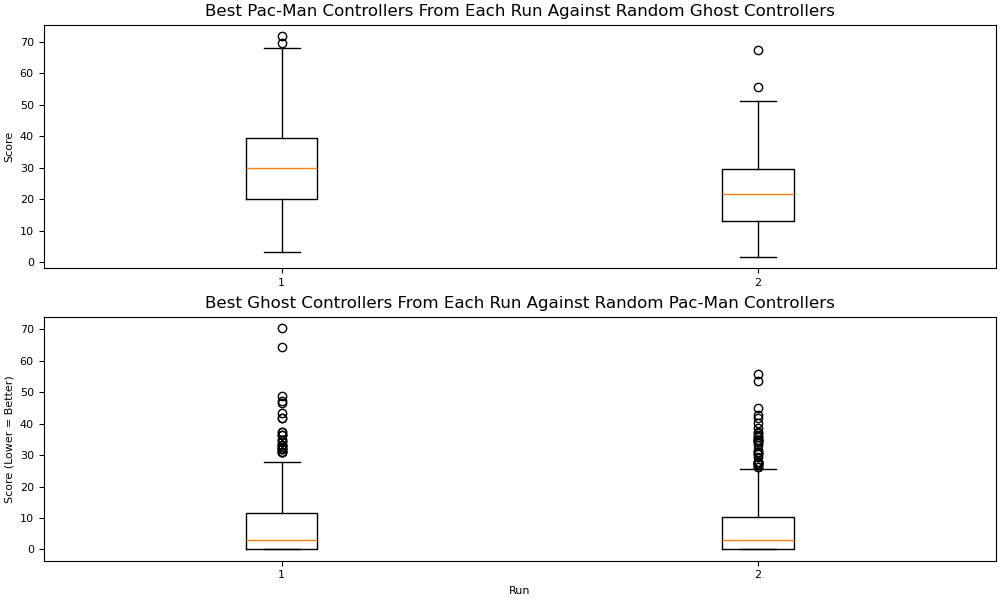

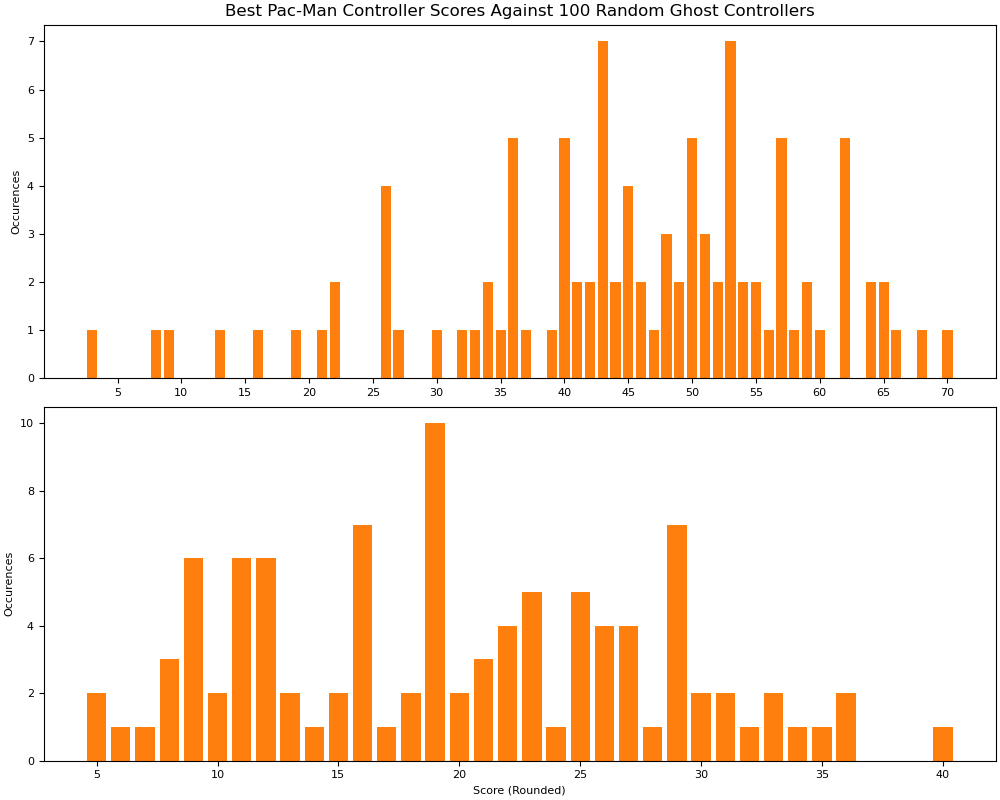

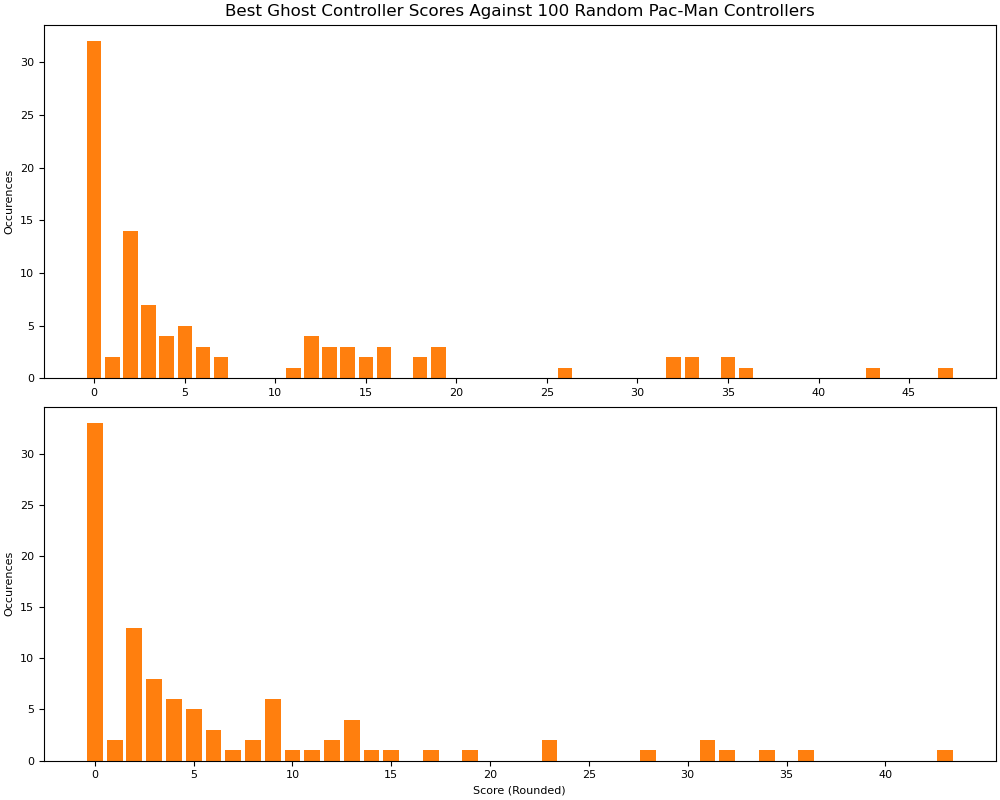

In [ ]:
post_hoc(pacs_per_run, ghosts_per_run, best_pacs, best_ghosts, combined_config, Path('./data/2c/example_post_hoc/'))

## Evals-vs-complexity Plot
We ask you to generate an evals-vs-complexity plot showing tree heights and tree sizes for each population at each generation, with lines showing the mean values and shaded regions showing the range of the min/max values. For this, you need to calculate three things for each of the four statistics at each generation: the mean, the min, and the max. Complete the below function by calculating these values.

In [14]:
def evals_vs_complexity(pac_heights_per_gen_per_run, ghost_heights_per_gen_per_run, \
                        pac_sizes_per_gen_per_run, ghost_sizes_per_gen_per_run, \
                        evaluation_counts, title, filename):
    # TODO: Calculate the mean, min, and max of each of the four statistics at each generation,
    #       storing them in the below variables.
    mean_pac_heights = []
    min_pac_heights = []
    max_pac_heights = []
    mean_ghost_heights = []
    min_ghost_heights = []
    max_ghost_heights = []
    mean_pac_sizes = []
    min_pac_sizes = []
    max_pac_sizes = []
    mean_ghost_sizes = []
    min_ghost_sizes = []
    max_ghost_sizes = []
    
    for j in range(len(pac_heights_per_gen_per_run[0])):
        curr_gen_mean_pac_height = statistics.mean([height for i in range(len(pac_heights_per_gen_per_run)) for height in pac_heights_per_gen_per_run[i][j]])
        curr_gen_min_pac_height = min([height for i in range(len(pac_heights_per_gen_per_run)) for height in pac_heights_per_gen_per_run[i][j]])
        curr_gen_max_pac_height = max([height for i in range(len(pac_heights_per_gen_per_run)) for height in pac_heights_per_gen_per_run[i][j]])
        
        curr_gen_mean_ghost_height = statistics.mean([height for i in range(len(ghost_heights_per_gen_per_run)) for height in ghost_heights_per_gen_per_run[i][j]])
        curr_gen_min_ghost_height = min([height for i in range(len(ghost_heights_per_gen_per_run)) for height in ghost_heights_per_gen_per_run[i][j]])
        curr_gen_max_ghost_height = max([height for i in range(len(ghost_heights_per_gen_per_run)) for height in ghost_heights_per_gen_per_run[i][j]])
        
        curr_gen_mean_pac_size = statistics.mean([size for i in range(len(pac_sizes_per_gen_per_run)) for size in pac_sizes_per_gen_per_run[i][j]])
        curr_gen_min_pac_size = min([size for i in range(len(pac_sizes_per_gen_per_run)) for size in pac_sizes_per_gen_per_run[i][j]])
        curr_gen_max_pac_size = max([size for i in range(len(pac_sizes_per_gen_per_run)) for size in pac_sizes_per_gen_per_run[i][j]])
        
        curr_gen_mean_ghost_size = statistics.mean([size for i in range(len(ghost_sizes_per_gen_per_run)) for size in ghost_sizes_per_gen_per_run[i][j]])
        curr_gen_min_ghost_size = min([size for i in range(len(ghost_sizes_per_gen_per_run)) for size in ghost_sizes_per_gen_per_run[i][j]])
        curr_gen_max_ghost_size = max([size for i in range(len(ghost_sizes_per_gen_per_run)) for size in ghost_sizes_per_gen_per_run[i][j]])

        mean_pac_heights.append(curr_gen_mean_pac_height)
        min_pac_heights.append(curr_gen_min_pac_height)
        max_pac_heights.append(curr_gen_max_pac_height)
        
        mean_ghost_heights.append(curr_gen_mean_ghost_height)
        min_ghost_heights.append(curr_gen_min_ghost_height)
        max_ghost_heights.append(curr_gen_max_ghost_height)
        
        mean_pac_sizes.append(curr_gen_mean_pac_size)
        min_pac_sizes.append(curr_gen_min_pac_size)
        max_pac_sizes.append(curr_gen_max_pac_size)
        
        mean_ghost_sizes.append(curr_gen_mean_ghost_size)
        min_ghost_sizes.append(curr_gen_min_ghost_size)
        max_ghost_sizes.append(curr_gen_max_ghost_size)

        
    with plt.ioff():
        fig, (pac_height_ax, ghost_height_ax, pac_size_ax, ghost_size_ax) = plt.subplots(nrows=4, figsize=(10.0, 12.0), sharex=True)

        pac_height_ax.plot(evaluation_counts, mean_pac_heights, color='tab:orange', label='Pacman')
        pac_height_ax.fill_between(evaluation_counts, min_pac_heights, max_pac_heights, color='tab:orange', alpha=0.2)
        ghost_height_ax.plot(evaluation_counts, mean_ghost_heights, color='b', label='Ghost')
        ghost_height_ax.fill_between(evaluation_counts, min_ghost_heights, max_ghost_heights, color='b', alpha=0.2)
        pac_size_ax.plot(evaluation_counts, mean_pac_sizes, color='tab:orange')
        pac_size_ax.fill_between(evaluation_counts, min_pac_sizes, max_pac_sizes, color='tab:orange', alpha=0.2)
        ghost_size_ax.plot(evaluation_counts, mean_ghost_sizes, color='b')
        ghost_size_ax.fill_between(evaluation_counts, min_ghost_sizes, max_ghost_sizes, color='b', alpha=0.2)
        pac_height_ax.set(ylabel='Height', title=title)
        ghost_height_ax.set(ylabel='Height')
        pac_size_ax.set(ylabel='Nodes')
        ghost_size_ax.set(ylabel='Nodes', xlabel='Evaluations')
        fig.legend(loc='outside lower center', ncols=2)
        
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = True
        fig.savefig(filename)
        fig.show()

You may use the following cell to generate a plot based on the data created from your test experiment.

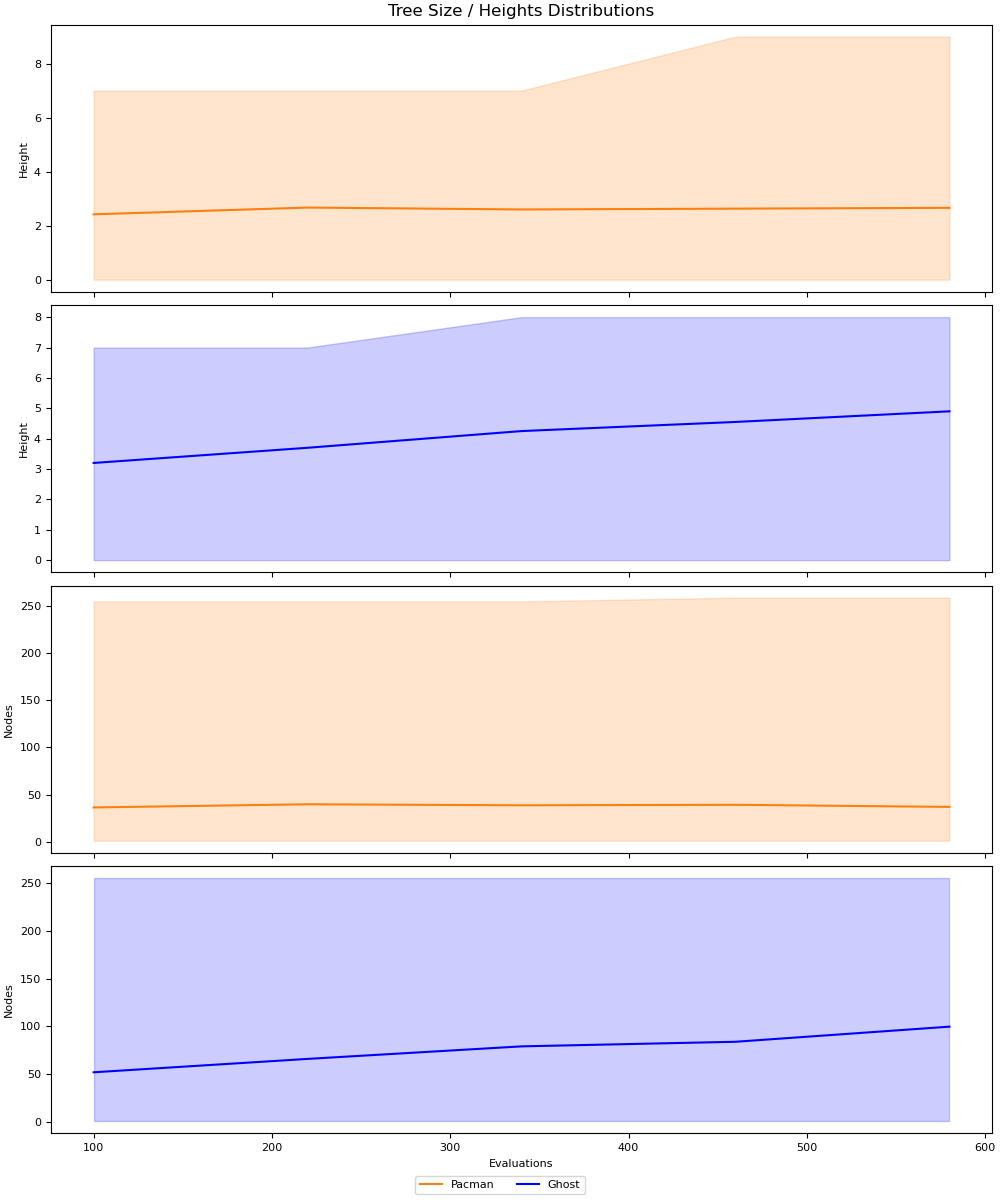

In [95]:
evals_vs_complexity(pac_heights_per_gen_per_run, ghost_heights_per_gen_per_run, \
                        pac_sizes_per_gen_per_run, ghost_sizes_per_gen_per_run, \
                        evaluation_counts, "Tree Size / Heights Distributions", "./data/2c/example_post_hoc/complexity_plots.png")

Since you will be running many different experiments, we will define one more function to reduce boilerplate. This function encapsulates both running an experiment and saving all the necessary data.

Note a subtle detail here: in the call to `post_hoc`, we're only passing the first _half_ of `best_pacs` and `best_ghosts`. This isn't particularly important until we get to the YELLOW analysis methodology, but we're going to go ahead and do it here to reduce the amount of data you need to analyze (and to make comparison with YELLOW more obvious, if you attempt that deliverable).

In [15]:
def experiment_and_save(num_runs, num_evaluations, config, data_dir):
    (
        pacs_per_run,
        ghosts_per_run,
        best_pacs,
        best_ghosts,
        pac_heights_per_gen_per_run,
        ghost_heights_per_gen_per_run,
        pac_sizes_per_gen_per_run,
        ghost_sizes_per_gen_per_run,
        evaluation_counts
    ) = competitive_gp_experiment(num_runs,
                                  num_evaluations,
                                  config)

    save_data(pacs_per_run,
              ghosts_per_run,
              best_pacs,
              best_ghosts,
              pac_heights_per_gen_per_run,
              ghost_heights_per_gen_per_run,
              pac_sizes_per_gen_per_run,
              ghost_sizes_per_gen_per_run,
              evaluation_counts,
              data_dir,
              config)

    animation = post_hoc(pacs_per_run,
                         ghosts_per_run,
                         best_pacs[:num_runs//2],
                         best_ghosts[:num_runs//2],
                         config,
                         data_dir / 'post_hoc')

    evals_vs_complexity(pac_heights_per_gen_per_run,
                        ghost_heights_per_gen_per_run,
                        pac_sizes_per_gen_per_run,
                        ghost_sizes_per_gen_per_run,
                        evaluation_counts,
                        f'Distributions of Height & Size vs Evaluations Over {num_runs} GP Runs',
                        data_dir / 'complexity_boxplots.png')

    return animation, pacs_per_run, ghosts_per_run, best_pacs, best_ghosts

## Tuning
While performance in competitive co-evolution is difficult to quantify, we remind you that the default config file contains parameters that are deliberately poor or nonsensical, and you will be penalized if your experiment was conducted without changing these parameters to more sensible values. You are required to utilize configurations that demonstrate a thorough understanding of the parameters' impacts. Also, **you are required to utilize a configuration that results in at least 25 generations** (including the initial population). Remember that, as discussed above, evaluation counts are different in this assignment than in any of your previous assignments, so be careful to make sure your configuration is actually satisfying this requirement.

As usual, the following cell defines a function to make tuning convenient:

In [16]:
def tuning_experiment(num_runs, num_evaluations, config_path):
    config = read_config(config_path, globals(), locals())
    config_text = config_path.read_text()

    # Set up a new subdirectory for us to save artifacts to
    base_subdir = Path('./tuning/') / config_path.parent.name / config_path.stem
    base_subdir.mkdir(parents=True, exist_ok=True)
    children = set(int(child.stem) for child in base_subdir.iterdir())
    if children:
        index = max(children) + 1
    else:
        index = 1
    subdir = base_subdir / str(index)

    # Run your GP experiment and save the data
    _ = experiment_and_save(num_runs, num_evaluations, config, subdir)

    # Make a copy of the config
    config_copy = subdir / config_path.name
    config_copy.write_text(config_path.read_text())

Now, tune the parameters in `configs/2c/green_config.txt`.

Data saved to tuning/2c/green_config/1


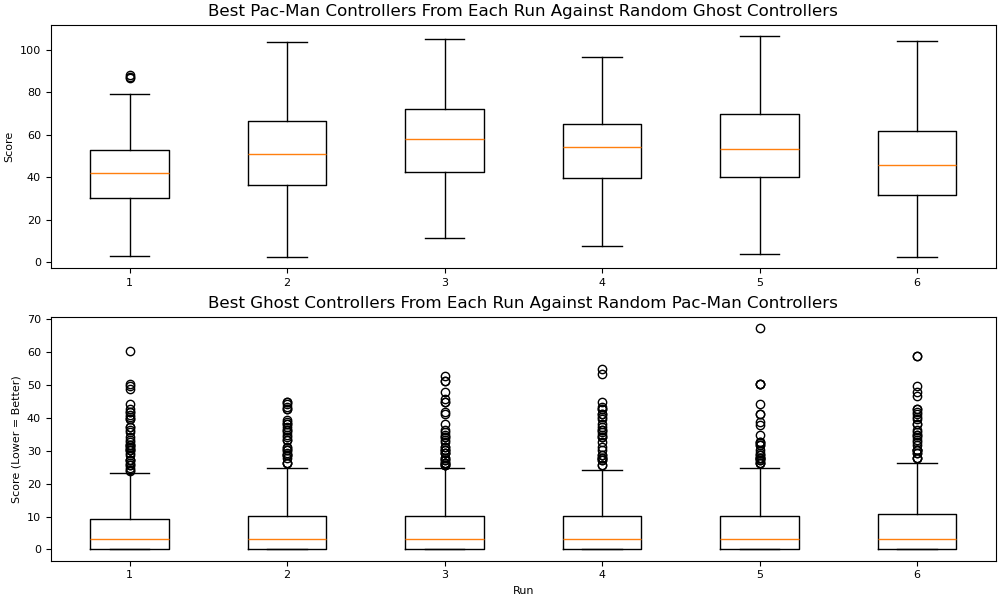

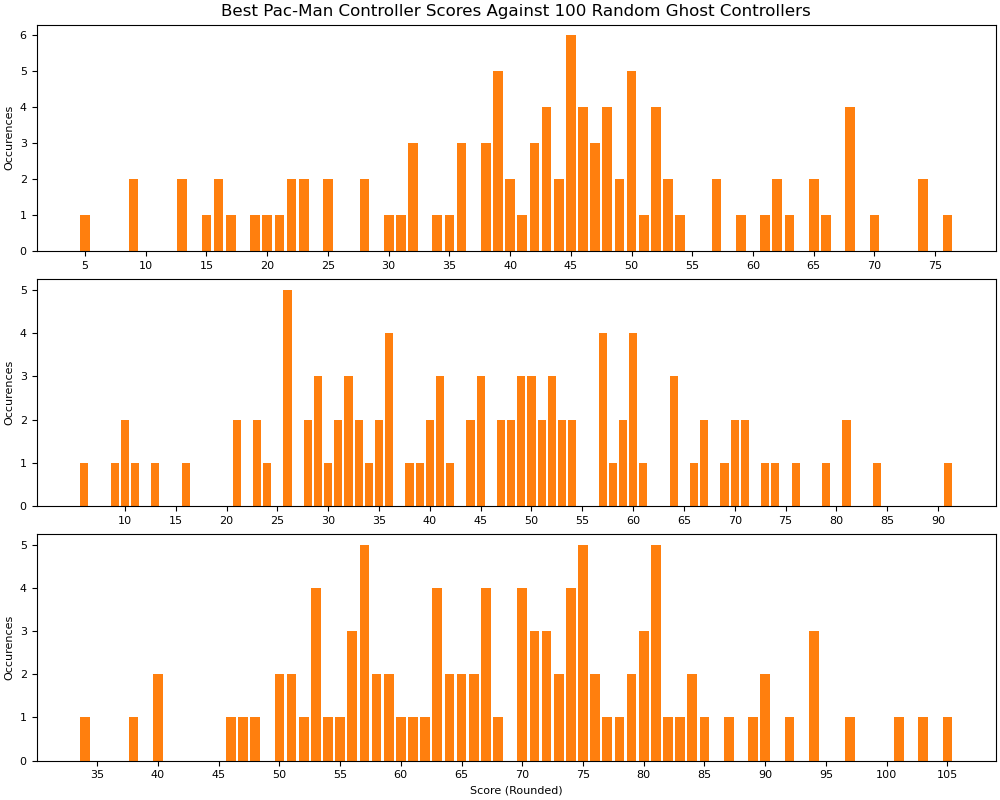

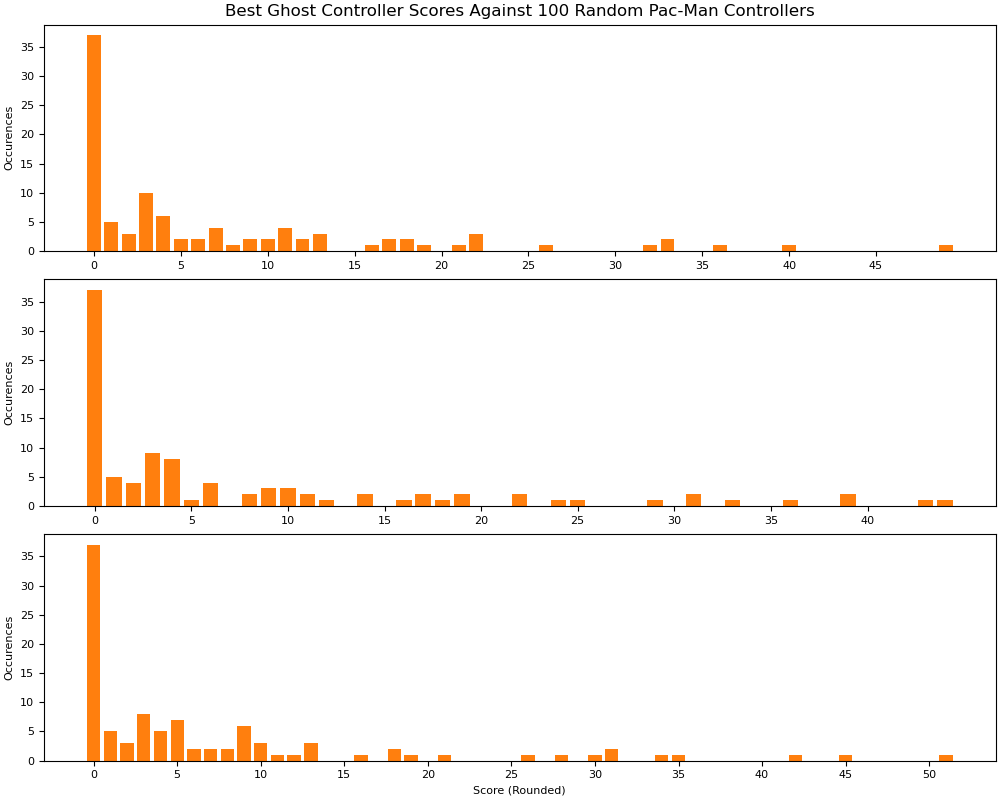

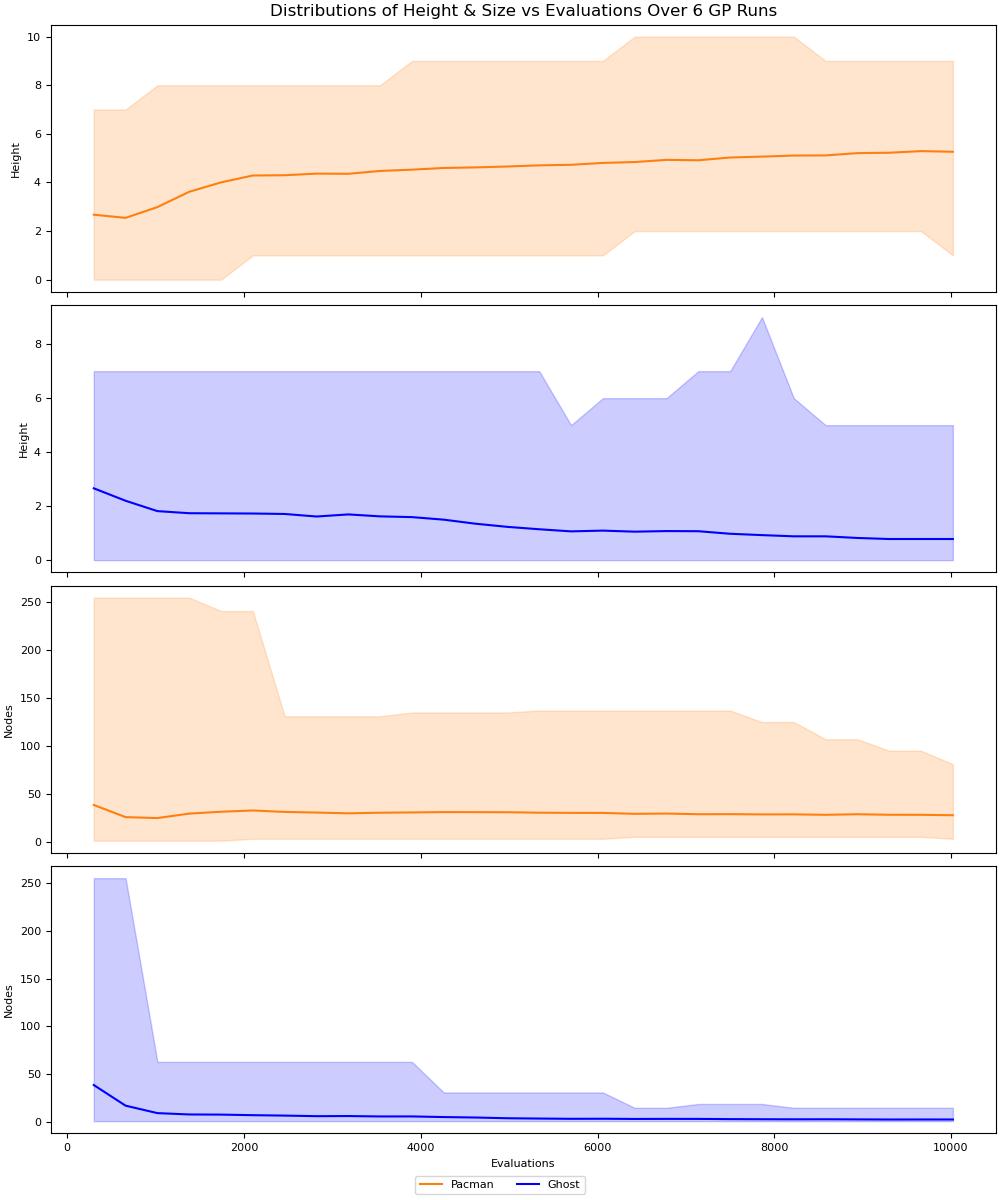

In [114]:
tuning_runs = 6 # Note you can increase this with no time loss if you have more CPU cores
num_evaluations = 10_000
green_config_path = Path('./configs/2c/green_config.txt')

tuning_experiment(tuning_runs, num_evaluations, green_config_path)

## Running Your Experiment
With your tuning complete, you can execute the following cell to run your full experiment!

Data saved to data/2c/green


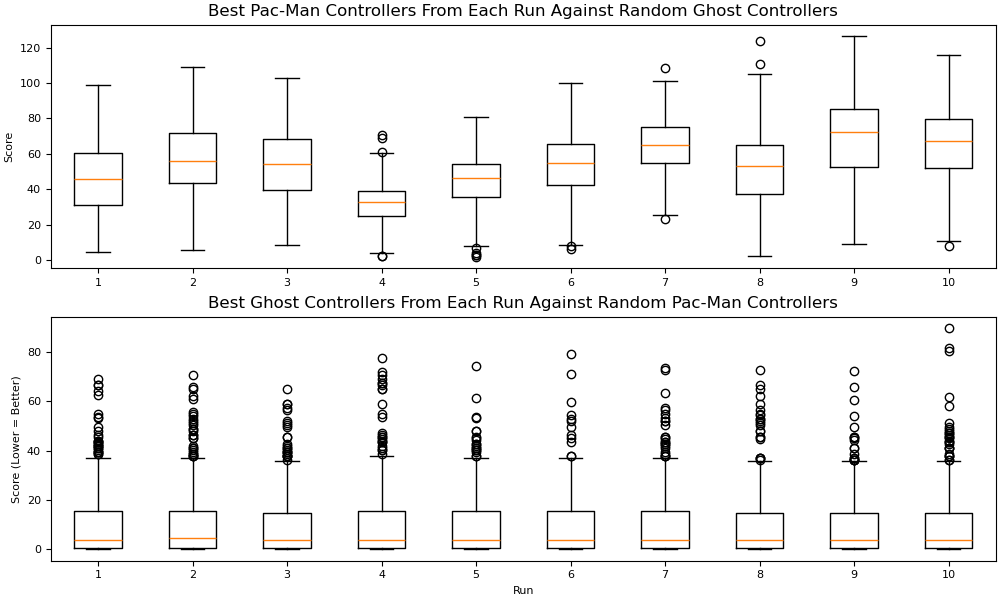

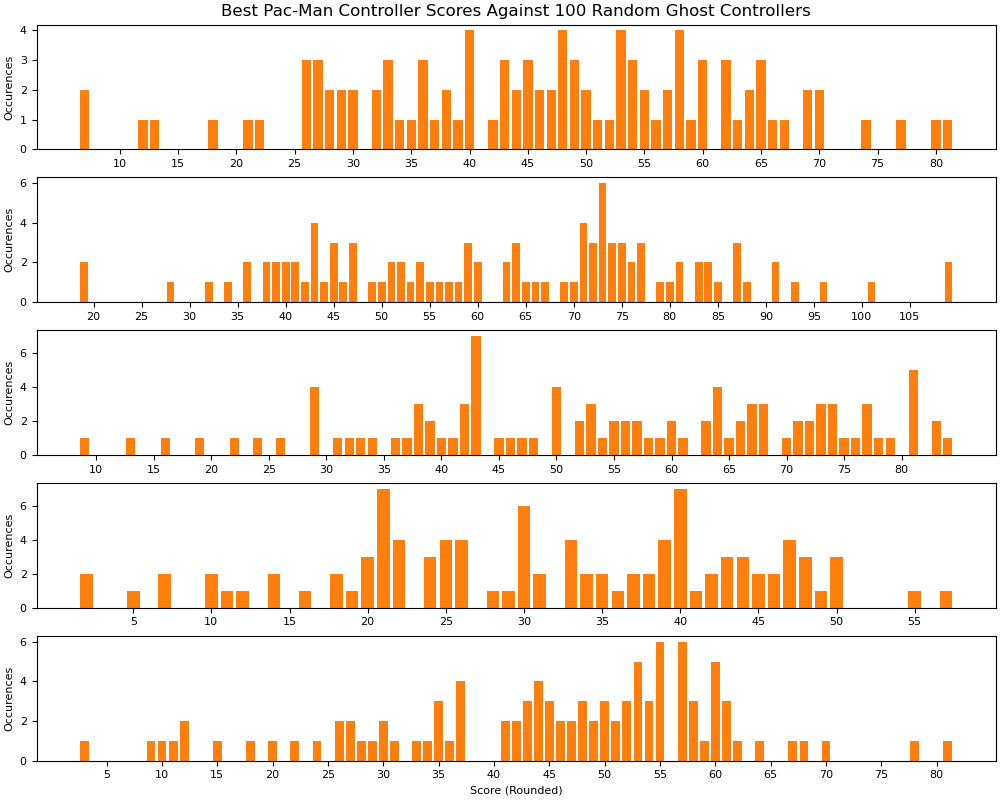

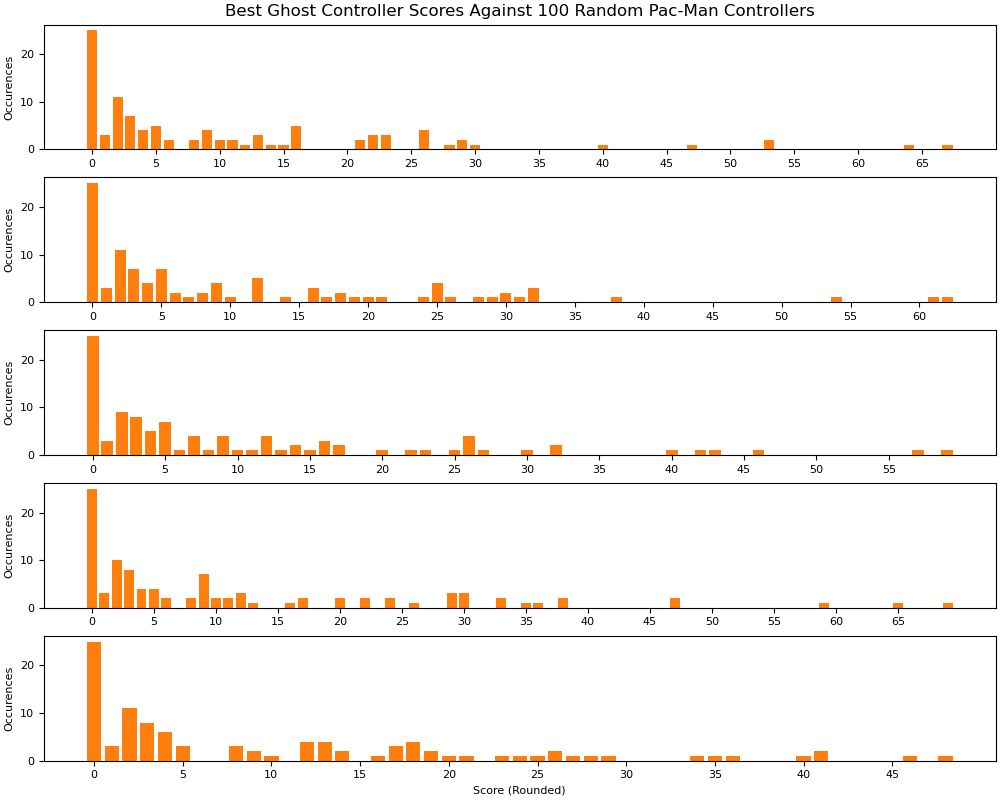

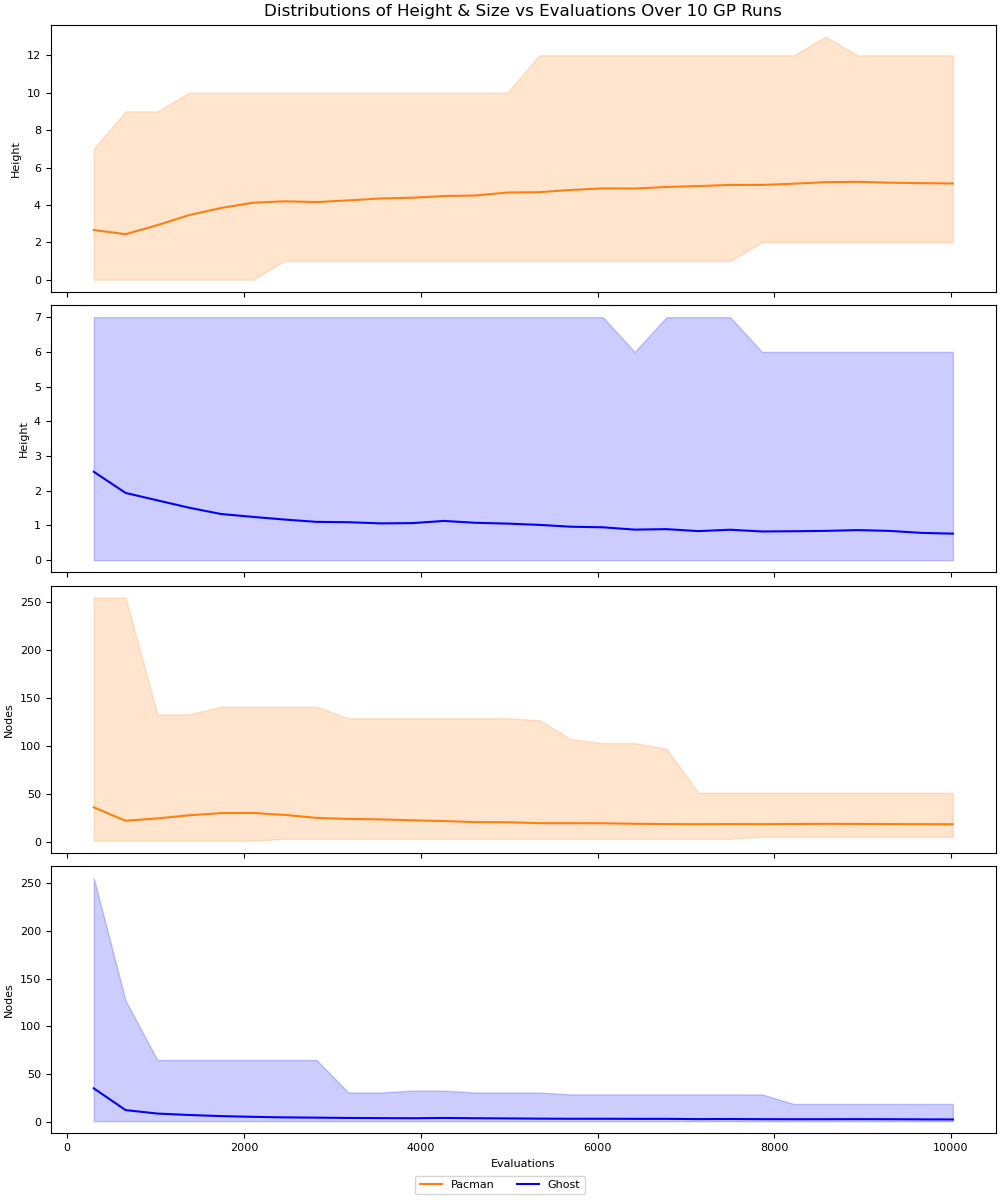

In [17]:
num_runs = 10
num_evaluations = 10_000
green_config = read_config('configs/2c/green_config.txt', globals(), locals())
green_data_path = Path('./data/2c/green/')

(
    animation,
    pacs_per_run,
    ghosts_per_run,
    best_pacs,
    best_ghosts
) = experiment_and_save(num_runs,
                        num_evaluations,
                        green_config,
                        green_data_path)

Run the following cell to watch the game between your two "best" controllers.

In [ ]:
display(HTML(animation))

## Report
Now you should have the data required to complete the report described in the assignment document.

# YELLOW Deliverable (Required for 6660 students, bonus for 5660 students)
Now that you've completed the GREEN deliverable and performed analysis against a reference set of randomly-generated opponents, we will experiment with another performance analysis technique. A potential shortcoming of the analysis method used in the GREEN deliverable is that the randomly-generated opponents don't represent the space of performant controllers very well. While performance against poor-performing agents may still be meaningful, it may not be very interesting if our focus is performing well against performant opponents (something addressed by the full analysis technique used in [1]). The 2009 publication *Why Coevolution Doesn't "Work": Superiority and Progress in Coevolution* [2] points out that many competitive coevolution studies suffer from analysis techniques that fail to separate a test set of opponents (those seen during co-evolution) from an evaluation set of opponents (not necessarily seen during co-evolution).

As a means of circumventing playing against known "test set" opponents while evaluating against opponents found using co-evolution, split the controllers found in your runs in half and have them compete against each other. Specifically, have the Pac-Man controllers from the first 5 runs play the Ghost controllers from the last 5 runs, while the Pac-Man controllers from the last 5 runs should play the Ghost controllers from the first 5 runs. Each pair of controllers should play against each other 10 times, to get a better sample of their performance, and their final score in that pairing should be taken as the average score of these 10 games.

Ultimately, you will be constructing a 5-dimensional matrix. As that can be a bit overwhelming to do all at once, we will guide you through writing functions to construct one dimension at a time, hierarchically.

As the first step in this task, finish implementing the stubbed-out function in the following cell. This function takes in a single Pac-Man controller, a single Ghost controller, and a config. It should return a list containing the scores from 10 games playing these two controllers against one another. That is, you simply need to play 10 games with the input controllers and return a list containing the scores from these games.

In [ ]:
def one_pac_one_ghost(pac, ghost, config):
    pass

Next, finish the function in the following cell to play a single Pac-Man controller against a group of Ghost controllers. It should return a 2-dimensional matrix where entry `[y][z]` is Pac-Man's score against the `y`th Ghost controller in the `z`th game they played. Note that this can be done very easily using the function you completed in the previous cell.

In [ ]:
def one_pac_many_ghosts(pac, ghosts, config):
    pass

Now you can finish the following function, which will play a group of Pac-Man controllers against a group of Ghost controllers. It should return a 3-dimensional matrix where entry `[x][y][z]` is the `x`th Pac-Man controller's score against the `y`th Ghost controller in the `z`th game they played. Again, this is very simple to do using the function from the previous cell. 

In [ ]:
def many_pacs_many_ghosts(pacs, ghosts, config):
    pass

Now we can get scores playing groups of Pac-Man controllers against groups of Ghost controllers. You're ready to write the final function, which will handle the top two dimensions. This function takes in the `pacs_per_run` and `ghosts_per_run` returned from your experiment function, which contain groups of five controllers from each run. Using these, produce a matrix where entry `[i][j]` is the result of calling your above function with the Pac-Man controllers from the `i`th run and the Ghost controllers from the `j`th run.

There's an important caveat here: you should only call the above function with the Pac-Man controllers from the first 5 runs and the Ghost controllers from the last 5 runs, OR with the Pac-Man controllers from the last 5 runs and the Ghost controllers from the first 5 runs. For the half of the entries that will not be played (such as `[2][4]` or `[8][6]`), set the values to `None`.

In [ ]:
def full_matrix(pacs_per_run, ghosts_per_run, config):
    pass

Now you can execute the following cell to run your above functions and visualize the results! Make sure to answer the questions below the code cell; that's also part of this YELLOW deliverable!

In [ ]:
from math import inf
import random

# We're just using your green config, as no new experiment was run
combined_config = read_config('configs/2c/green_config.txt', globals(), locals())
config, ghost_config = split_config(combined_config)

# Call your above function to get data for visualization
scores = full_matrix(pacs_per_run, ghosts_per_run, config)

averages = [[None for j in range(len(scores[i]))] for i in range(len(scores))]
rgbs = [[[] for j in range(len(scores[i]))] for i in range(len(scores))]
text = [[None for j in range(len(scores[i]))] for i in range(len(scores))]
max_avg = -inf
min_avg = inf
for i in range(len(scores)):
    for j in range(len(scores[i])):
        # Deliberately inverted; imshow is weird, rasters are column-major
        score = scores[j][i]
        if score is not None:
            avg = statistics.mean(entry for p in score for g in p for entry in g)
            averages[j][i] = avg
            if max_avg < avg:
                max_avg = avg
                max_avg_loc = (i, j)
            if min_avg > avg:
                min_avg = avg
                min_avg_loc = (i, j)

for i in range(len(scores)):
    for j in range(len(scores[i])):
        # Deliberately inverted; imshow is weird, rasters are column-major
        avg = averages[j][i]
        if avg is None:
            rgbs[j][i] = [1.0, 1.0, 1.0]
        else:
            # Scale the scores from [min_avg, max_avg] to [0, 1] for coloring
            scalar = (avg - min_avg) / (max_avg - min_avg)
            # This is hopefully still legible for people with deuteranopia
            # Feel free to modify the RGB calculations if you want
            rgbs[i][j] = [1 - scalar, scalar, (1 - scalar) / 2]
            text[i][j] = f'{avg:.1f}'

# Highlight the min and max scores with a unique color
rgbs[max_avg_loc[0]][max_avg_loc[1]] = [0.5, 0.5, 1.0]
rgbs[min_avg_loc[0]][min_avg_loc[1]] = [0.5, 0.5, 1.0]

with plt.ioff():
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(rgbs, origin='lower')
    for x in range(len(text)):
        for y in range(len(text[x])):
            if not text is None:
                ax.text(y, x, text[x][y], ha='center', va='center', fontsize='large')
    ax.set(title='Exhibition Game Matrix (Pac-Man score)', xlabel='Pac-Man', ylabel='Ghost')
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    Path('data/2c/yellow').mkdir(parents=True, exist_ok=True)
    fig.savefig('data/2c/yellow/matrix.png')
    fig.show()

**Question 1** (3%): Explain what intransitivity might look like in the above matrix plot. Do you see any signs of intransitivity in your plot?

Answer Question 1 here (double-click to edit)

**Question 2** (2%): How would the existence of intransitivity inhibit your ability to identify the singular-best agent?

Answer Question 2 here (double-click to edit)

In addition, we will use the data generated here to create histograms similar to the ones created for GREEN. Note that we're visualizing distributions for the same controllers, so you can directly compare the results. Where the GREEN histograms showed the distribution of their performance against randomly-generated opponents, these histograms will show their performance against evolved opponents. Note that we're taking the average across the 10 matches played in each pairing before putting the data into the histogram.

In [ ]:
pac_hists = []
ghost_hists = []

for i in range(5):
    hist = BaseHistogramMaker()
    pac_index = pacs_per_run[i].index(best_pacs[i])
    for j in range(5, 10):
        for y in range(len(scores[i][j][pac_index])):
            hist.add(int(round(statistics.mean(scores[i][j][pac_index][y]))))
    pac_hists.append(hist)

for j in range(5):
    hist = BaseHistogramMaker()
    ghost_index = ghosts_per_run[j].index(best_ghosts[j])
    for i in range(5, 10):
        for x in range(len(scores[i][j])):
            hist.add(int(round(statistics.mean(scores[i][j][x][ghost_index]))))
    ghost_hists.append(hist)

def make_hists(hists, title, filename, txt_prefix):
    # Generate the best-controller histograms
    fig, axs = plt.subplots(nrows=len(hists), figsize=(10.0, 8.0))
    for run, hist in enumerate(hists):
        ax = axs[run]
        hist.save_to_file(Path('data/2c/yellow') / f'{txt_prefix}_{run}.txt')
        ticks = hist.get_plot((fig, ax))
        ax.set(ylabel='Occurences')
        ax.set_xticks(ticks, ticks)
    axs[-1].set(xlabel='Score (Rounded)')
    axs[0].set(title=title)
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.savefig(filename)
    fig.show()

make_hists(pac_hists, 'Best Pac-Man Controller Scores Against Evolved Ghost Controllers',
           Path('data/2c/yellow') / 'pac_histograms.png', 'pac_hist')
make_hists(ghost_hists, 'Best Ghost Controller Scores Against Evolved Pac-Man Controllers',
           Path('data/2c/yellow') / 'ghost_histograms.png', 'ghost_hist')

Place the visualizations in your report. For information about the shortcomings of this approach, see the appendix of this notebook.

**Question 3** (2%): Do these distributions differ meaningfully from those obtained using the GREEN analysis method?

Answer Question 3 here (double-click to edit)

**Question 4** (3%): How does a multimodal distribution of scores impact the meaningfulness of measures of central tendency for representing performance?

Answer Question 4 here (double-click to edit)

# RED Deliverables
Feel free to create more notebook cells for RED deliverables as necessary. Here are some comments on those deliverables.

### Config Files
For the RED deliverables in this assignment, you are tasked with creating your own config files. For many of the RED deliverables, you can use the provided config files and code as inspiration for new config files and the parsing of those files, respectively.

### Modified Fitness Function
The RED deliverables require a modified version of the `play_GPac` function. See the last cell of `2b_notebook.ipynb` for more information.

## References
[1] Wojciech Jaśkowski, Paweł Liskowski, Marcin Szubert, and Krzysztof Krawiec. 2013. Improving coevolution by random sampling. In Proceedings of the 15th annual conference on Genetic and evolutionary computation (GECCO '13). Association for Computing Machinery, New York, NY, USA, 1141–1148. https://doi.org/10.1145/2463372.2463512

[2] Thomas Miconi. 2009. Why Coevolution Doesn't "Work": Superiority and Progress in Coevolution. In Proceedings of the 12th European Conference on Genetic Programming (EuroGP '09). Springer-Verlag, Berlin, Heidelberg, 49–60. https://doi.org/10.1007/978-3-642-01181-8_5

## Appendix

### GREEN Analysis Method Shortcomings
As mentioned previously in the notebook, our analysis method in GREEN is lacking rigor compared to the methods used in [1]. In [1], the methodology employed uses much larger populations of randomly-generated opponents that play against a still larger population of random opponents and are sorted based on performance. This seemingly worked well in [1] because the strategy representation is essentially a linear sequence of actions. For more complicated controllers with stochasticity (e.g., the `RAND` primitive), the idea of playing against randomly generated opponents at all has meaningful issues. First, random search has no guarantee of exploring performant strategy space. In other words, the agents you want to assess may only play against poor-performing and uninteresting opponents (compared to performant strategies discovered through other optimization approaches). Second, a single game between two given controllers may not be representative of the performance of either controller against one another. Depending on the amount of stochasticity in the controllers and the problem itself, it may take an intractable number of games to determine an accurate mean score for all pairs of agents used in analysis. As such, this method was not originally intended for use on competitions with stochasticity. Third, the representative strategy was selected as the highest-fitness individuals from each population at the last generation of co-evolution and their fitnesses may have been approximated through competition with as few as one opponent. As a result, there's a very good chance the representative agent of each run is not the best agent discovered throughout the entire run, but rather an agent that was just paired against a poorly-performing agent in the final generation. Solving these issues requires being able to meaningfully assess global performance against all possible strategies [2], which is an open area of research.

### YELLOW Analysis Method Shortcomings
As was the case with the GREEN analysis method, the YELLOW analysis method also suffers from issues pertaining to stochasticity during competition between two strategies and difficulties in selecting the strategy found during each run that has the best global performance against all possible opponents [2]. The latter issue (using representatives that may not have the best global performance in the run) is somewhat exacerbated in this technique, since the primary improvement over the GREEN analysis method is competition against performant opponents. Additionally, since such few opponents are being used, issues with intransitivity can arise. Namely, if a strategy is well-suited for competition against a particular type of high-performing strategy that happens to not be well-represented in the evaluation set of opponents, then the performance of that strategy may appear deceptively low.